In [1]:
#%%
import re
import os
# add the parent directory to the path
import sys
sys.path.append('../../')
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal
from utils import *
import seaborn as sns

ab_folder_path = '../experiment_data/tk_03152024/AB'
od_folder_path = '../experiment_data/tk_03152024/OD'

exp_layout = {0.1:(0,['B','C','D']),
              1:(0,['E','F','G']),
              10:(1,['B','C','D']),
              100:(1,['E','F','G'])}

# These functions help with sorting the file names in natural order
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


# pickle_file = '../calibration_code/calibration_02152024.pkl'
pickle_file = '../calibration_code/calibration_02152024.pkl'
res = pickle.load(open(pickle_file,'rb'))

def ab_to_cfu(ab):
    return 10**(res.slope*np.log10(ab) + res.intercept)

rfu30_to_dilution = cal.run()

def od_to_cfu(OD):
    slope = 0.94
    intercept = 5.75
    return 10**(np.log10(OD) * slope + intercept)

In [86]:
cell_count_mean_od = {}
cell_count_std_od = {}

cell_count_raw_od = {}

od_raw = {}
od_raw_std = {}

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(od_folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,6))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
    
            if i >= 3:
                col= str(i+4)
            else:
                col = str(i+3)

            key = row + col
            
            data_t[row_indx,i] = data[i][key] - 0.05
            # col_indx += 1
            row_indx += 1

    # cell_count_data = rfu_to_dilution(data_t,background_subtracted=False)
    data_t[data_t <= 0] = 10**-4
    cell_count = od_to_cfu(data_t)
    # cell_count_log = rfu_to_dilution.predict(rfu_t.reshape(-1,1))

    cell_count_mean_od[exp_key] = np.mean(cell_count,axis=0)
    cell_count_std_od[exp_key] = np.std(cell_count,axis=0)

    cell_count_raw_od[exp_key] = cell_count

    od_raw[exp_key] = data_t
    od_raw_std[exp_key] = np.std(data_t,axis=0)

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time_od = np.array(time)

In [93]:
data_t

array([[0.0819, 0.123 , 0.1979, 0.0049, 0.0027, 0.0057],
       [0.1918, 0.1101, 0.0477, 0.1209, 0.0032, 0.0062],
       [0.0986, 0.1152, 0.0827, 0.0125, 0.0004, 0.0027]])

In [94]:
cell_count_mean_ab = {}
cell_count_std_ab = {}

cell_count_raw_ab = {}

ab_raw = {}
ab_raw_std = {}

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(ab_folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,7))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key] - 200
            # col_indx += 1
            row_indx += 1

    # cell_count_data = rfu_to_dilution(data_t,background_subtracted=False)
    # data_t[data_t <= 0] = 1
    # cell_count = rfu30_to_dilution(data_t,background_subtracted=True)
    cell_count = ab_to_cfu(data_t)
    # cell_count_log = rfu_to_dilution.predict(rfu_t.reshape(-1,1))

    cell_count_mean_ab[exp_key] = np.mean(cell_count,axis=0)
    cell_count_std_ab[exp_key] = np.std(cell_count,axis=0)

    cell_count_raw_ab[exp_key] = cell_count

    ab_raw[exp_key] = data_t
    ab_raw_std[exp_key] = np.std(data_t,axis=0)

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time_ab = np.array(time)

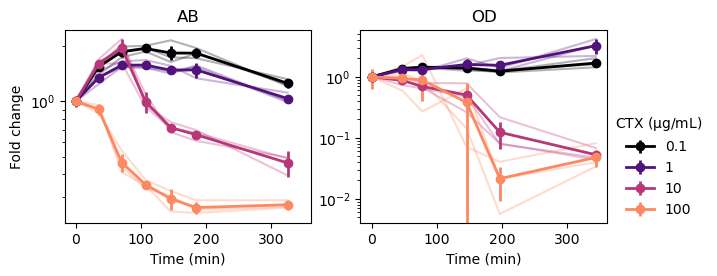

In [113]:
fig,ax_list = plt.subplots(ncols=2,figsize=(7,2.5),sharey=False,sharex=True)

cmap = sns.color_palette("magma", as_cmap=True)

keys = [0.1,1,10,100]
ax = ax_list[0]
# for j,exp_key in enumerate(exp_layout.keys()):
for j,exp_key in enumerate(keys):
    for i in range(3):
        y = cell_count_raw_ab[exp_key][i]
        # err = cell_count_std_ab[exp_key]

        # y = y/ctrl
        # err = err/y[0]
        y = y/y[0]
        ax.plot(time_ab,y,color=cmap(j/4),alpha=0.3)
        # ax.errorbar(time_ab,y,yerr=err,fmt='-o',color=cmap(j/4))

    y = cell_count_mean_ab[exp_key]
    err = cell_count_std_ab[exp_key]

    err = err/y[0]
    y = y/y[0]

    ax.errorbar(time_ab,y,yerr=err,fmt='-o',color=cmap(j/4),label=exp_key,linewidth=2)

ax.set_yscale('log')

ax = ax_list[1]
for j,exp_key in enumerate(keys):
    
    for i in range(3):
        y = cell_count_raw_od[exp_key][i]
        # err = cell_count_std_od[exp_key]

        # err = err/y[0]
        y = y/y[0]
        ax.plot(time_od,y,color=cmap(j/4),alpha=0.3)
        # ax.errorbar(time_od,y,yerr=err,color=cmap(j/4),fmt='-o',label=exp_key)

    y = cell_count_mean_od[exp_key]
    err = cell_count_std_od[exp_key]

    err = err/y[0]
    y = y/y[0]
    
    ax.errorbar(time_od,y,yerr=err,color=cmap(j/4),fmt='-o',label=exp_key,linewidth=2)
    
# ax.set_yscale('symlog',linthresh=0.7)
ax.set_yscale('log')
        
# for ax in ax_list:
#     ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

ax_list[0].set_xlabel('Time (min)')
ax_list[1].set_xlabel('Time (min)')
ax_list[0].set_ylabel('Fold change')

# cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),ax=ax,
            # label='TET ($\mathrm{\mu g/mL}$)',orientation='horizontal',pad=0.2)
            # boundari)

# cbar.set_ticks([0,0.3,0.75])
# # cbar.set_ticklabels([50,100,400])

ax_list[1].legend(frameon=False,ncol=1,title='CTX ($\mathrm{\mu g/mL}$)',
                  loc = [1.01,0])

ax_list[0].set_title('AB')
ax_list[1].set_title('OD')

# ax_list[0].set_ylim([0.1*10**-1,10])

fig.savefig('../../figures/ab_vs_od.pdf',bbox_inches='tight',transparent=True)

In [110]:
cell_count_std_od

{0.1: array([ 5936.01060572,  5193.01384402,  7561.82109493,  8114.79302662,
         3324.58119425, 21028.25623953]),
 1: array([ 2562.57490088,  3946.94954753,  6999.47436196, 23932.54816066,
        20402.39956135, 64669.30957052]),
 10: array([ 4494.73831757,  5672.69586787,  3155.45601951, 16880.21908673,
         5004.20081673,   742.43450833]),
 100: array([28810.53726633,  3189.81740471, 38540.87883009, 33403.84882722,
          951.84194535,  1133.84310613])}